In [2]:
# enable inline plotting
%matplotlib inline
# uncomment this line to open a console with the same kernel
# %qtconsole

import numpy as np
import pandas as pd
import cma
from scipy import stats

import matplotlib.pyplot as plt

from kkr import *

configure some parameters

In [3]:
default_alpha_t = -4
default_alpha_o = -4
default_alpha_q = -4

# bandwidth of the kernel function k and g
default_bandwidth_factor_k = np.log(1)
default_bandwidth_factor_g = np.log(1)

# Simulation parameters
num_steps = 30
num_episodes = 100
# observation_idx = [0, 1] + list(range(5,30,5)) + [28, 29]
observation_idx = list(range(30))
observation_idx_2 = [0, 1, 2, 3] + list(range(5,25,5)) + [26, 27, 28, 29]

num_test_episodes = 10
num_eval_episodes = 10

process_noise_std = .01
observation_noise_std = .2

# Model parameters
# number of data points in the kernel matrices
kernel_size = 200
subspace_size = 150

window_size = 4

state_features = 'thetaNoisy'
obs_features = 'thetaNoisy'

Simulate the data

In [4]:
np.random.seed(2)

# Simulate pendulum
pendulum = Pendulum()
pendulum.noise_std = process_noise_std
pendulum.dt = .1

simulator = Simulator(pendulum, stats.uniform(loc=np.array([-.25, -2]) * np.pi, scale=np.array([.5, 4]) * np.pi).rvs)

# sample train data
data = simulator.simulate(num_episodes, num_steps)
add_noise(data, 'theta', noise_generator=stats.norm(loc=.0, scale=observation_noise_std))
# Sample test data
test_data = simulator.simulate(num_test_episodes, num_steps)
add_noise(test_data, 'theta', noise_generator=stats.norm(loc=.0, scale=observation_noise_std))
# sample eval data
eval_data = simulator.simulate(num_eval_episodes, num_steps)
add_noise(eval_data, 'theta', noise_generator=stats.norm(loc=.0, scale=observation_noise_std))

In [5]:
# create observations
test_data['observations'] = test_data.loc[(slice(None), observation_idx), obs_features]
test_data['observations_2'] = test_data.loc[(slice(None), observation_idx_2), obs_features]
eval_data['observations'] = eval_data.loc[(slice(None), observation_idx_2), obs_features]

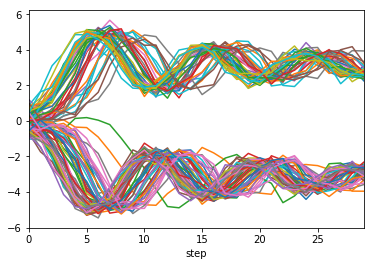

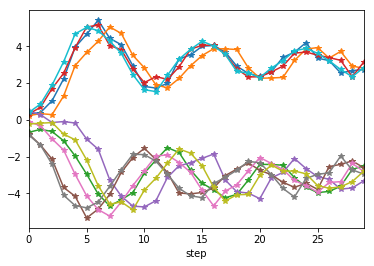

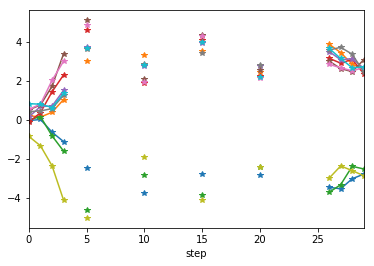

In [6]:
_ = data['thetaNoisy'].unstack(0).plot(legend=False)
_ = test_data['observations'].unstack(0).plot(marker='*', legend=False)
_ = eval_data['observations'].unstack(0).plot(marker='*', legend=False)

## Preprocess the data

Now we learn the filter from this data. First, we need to create data windows to make the data more Markovian. See [here](preprocessor/preprocessors.py) for how the data windows are generated.

In [7]:
windows = generate_data_windows(data[state_features], window_size)

# get initial states of the data
gb = windows.groupby(level='episode')
_X0 = gb.first()[state_features].values
_XT = gb.tail()[state_features].values

## Compute the bandwidths

In [8]:
bandwidths = compute_median_bandwidth(windows[state_features])

## Select training data

In [9]:
kernel_ref = ExponentialQuadraticKernel()
kernel_ref.bandwidth = bandwidths
reference_set1, reference_set2, reference_set3 = \
        select_reference_set_by_kernel_activation(windows, size=kernel_size, 
                                                  kernel_function=kernel_ref,
                                                  consecutive_sets=3, group_by='episode')
reference_set_subspace = select_reference_set_by_kernel_activation(windows.loc[reference_set1],
                                                                   size=subspace_size,
                                                                   kernel_function=kernel_ref)

_X1 = windows.loc[reference_set1, state_features].values
_X2 = windows.loc[reference_set2, state_features].values
_X3 = windows.loc[reference_set3, state_features].values
_Y1 = data.loc[reference_set1, obs_features].values.reshape((-1, 1))
_Y2 = data.loc[reference_set2, obs_features].values.reshape((-1, 1))
_Xr = windows.loc[reference_set_subspace, state_features].values
# _Xout = data.loc[reference_set2, out_features].values

observations = test_data['observations'].unstack(level=0).values
observation_dim = test_data['observations'].ndim
observations = observations.reshape(-1, observation_dim, num_test_episodes)

groundtruth = test_data['theta'].unstack(level=0).values
groundtruth_dim = test_data['theta'].ndim
groundtruth = groundtruth.reshape(-1, groundtruth_dim, num_test_episodes)

## Create a KFBS Experiment

In [11]:
evaluation = SmootherEvaluation()
# evaluation.model_class = SubspaceKernelForwardBackwardSmoother

train_matrices = {'states_1': _X1,
                  'states_2': _X2,
                  'states_3': _X3,
#                   'subspace_states': _Xr,
                  'observations': _Y2,
                  'init_fw_states': _X0,
                  'init_bw_states': _XT,
                  'preimage_states': _Y2}

evaluation.setup_evaluation(train_data=train_matrices, test_observations=observations,
                            test_groundtruth=groundtruth)

parameter_names = ['bandwidth_k', 'bandwidth_g',
                   'alpha_t', 'alpha_o', 'alpha_q',
                   'alpha_t_bw', 'alpha_o_bw', 'alpha_q_bw']


@parameter_naming(parameter_names)
@parameter_transform(np.exp)
@bandwidth_factor(bandwidth_k=bandwidths, bandwidth_g=bandwidths[0])
@exception_catcher(np.linalg.linalg.LinAlgError, 1e10)
def eval_experiment(**kwargs):
    return evaluation.evaluate_loglikelihood(**kwargs)
                            

### Optimize parameters

In [66]:
x_0 = [default_bandwidth_factor_k, default_bandwidth_factor_g,
       default_alpha_t, default_alpha_o, default_alpha_q,
       default_alpha_t, default_alpha_o, default_alpha_q]

cma_opt = cma.CMAEvolutionStrategy(x_0, 1.5)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=223316, Sat Aug 19 16:49:03 2017)


In [96]:
cma_opt.optimize(objective_fct=eval_experiment, iterations=50, verb_disp=1)

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  101   1010 2.733085242023712e+03 1.2e+01 3.94e-01  6e-02  4e-01 87:38.3
  102   1020 2.731024610873031e+03 1.3e+01 3.72e-01  5e-02  4e-01 88:0.4
  103   1030 2.688619508853477e+03 1.3e+01 3.19e-01  4e-02  3e-01 88:26.5
  104   1040 2.723148205952132e+03 1.4e+01 3.07e-01  4e-02  3e-01 88:49.3
  105   1050 2.673635424700642e+03 1.4e+01 2.81e-01  4e-02  3e-01 89:18.4
  106   1060 2.680203874704770e+03 1.5e+01 2.60e-01  3e-02  3e-01 89:52.4
  107   1070 2.667058229267055e+03 1.5e+01 2.48e-01  3e-02  3e-01 90:25.0
  108   1080 2.654427780235963e+03 1.5e+01 2.65e-01  3e-02  3e-01 90:52.8
  109   1090 2.637110450058247e+03 1.5e+01 2.67e-01  3e-02  3e-01 91:18.2
  110   1100 2.655745383243738e+03 1.6e+01 2.44e-01  3e-02  2e-01 91:42.2
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  111   1110 2.658813098912043e+03 1.6e+01 2.15e-01  2e-02  2e-01 92:6.0
  112   1120 2.649389365451579e+03 1.6e+01 1

(array([ 0.24588998,  0.25434764, -3.84997241, -5.59327977, -7.30817687,
        -2.30717698, -7.84645525, -8.29416718]),
 -10984.610552578139,
 484,
 1500,
 150,
 array([ 0.44295389, -0.5073167 , -8.08688046, -4.12866778, -7.00581802,
        -9.09772127, -6.63665134, -6.13263709]),
 array([ 0.00239295,  0.00158277,  0.02398848,  0.02032852,  0.00393269,
         0.01578621,  0.01804948,  0.00843255]))

Continue learning with partial observations

In [12]:
observations_2 = test_data['observations_2'].unstack(level=0).values
observation_dim = test_data['observations_2'].ndim
observations_2 = observations.reshape(-1, observation_dim, num_test_episodes)

evaluation.setup_evaluation(train_data=train_matrices, test_observations=observations,
                            test_groundtruth=groundtruth)

In [ ]:
cma_opt.optimize(objective_fct=eval_experiment, iterations=100, verb_disp=1)

### Retrieve to optimal parameters

In [97]:
result = cma_opt.result()

best_params = dict(zip(parameter_names, np.exp(result[0])))

best_params

{'alpha_o': 0.0037227979079106997,
 'alpha_o_bw': 0.00039113599375211058,
 'alpha_q': 0.00067003750757144425,
 'alpha_q_bw': 0.00024997061746557641,
 'alpha_t': 0.021280323639060992,
 'alpha_t_bw': 0.099541863962014115,
 'bandwidth_g': 1.2896200531257855,
 'bandwidth_k': 1.2787588815066497}

In [13]:
best_params = {'alpha_o': 0.0037227979079106997,
 'alpha_o_bw': 0.00039113599375211058,
 'alpha_q': 0.00067003750757144425,
 'alpha_q_bw': 0.00024997061746557641,
 'alpha_t': 0.021280323639060992,
 'alpha_t_bw': 0.099541863962014115,
 'bandwidth_g': 1.2896200531257855,
 'bandwidth_k': 1.2787588815066497}

In [98]:
dict(zip(parameter_names, result[0]))

{'alpha_o': -5.5932797676194879,
 'alpha_o_bw': -7.8464552483431227,
 'alpha_q': -7.3081768656962485,
 'alpha_q_bw': -8.2941671771469299,
 'alpha_t': -3.8499724060218528,
 'alpha_t_bw': -2.307176979968423,
 'bandwidth_g': 0.25434764252974557,
 'bandwidth_k': 0.24588998371932524}

### Re-Learn the KFBS

In [14]:
# best_params['alpha_t_bw'] = best_params['alpha_t']
# best_params['alpha_o_bw'] = best_params['alpha_o']

evaluation.model.learn_model(**best_params)

## Evaluate

In [15]:
observations = eval_data['observations'].unstack(level=0).values

observations = observations.reshape(-1, 1, num_test_episodes)

# mu, sigma = kernel_kalman_filter.filter(observations)

evaluation.model

mu_fw, sigma_fw = evaluation.model.filter(observations)

mu_bw, sigma_bw = evaluation.model.filter_bw(np.flipud(observations))
mu_bw = np.flipud(mu_bw)
sigma_bw = np.flipud(sigma_bw)

mu_sm, sigma_sm = evaluation.model.smooth(observations)

eval_data['mu_fw'] = np.moveaxis(mu_fw, 2, 0).reshape(-1, 1)
eval_data['sigma_fw'] = np.tile(np.squeeze(np.sqrt(sigma_fw)), num_test_episodes)
eval_data['mu_bw'] = np.moveaxis(mu_bw, 2, 0).reshape(-1, 1)
eval_data['sigma_bw'] = np.tile(np.squeeze(np.sqrt(sigma_bw)), num_test_episodes)
eval_data['mu_sm'] = np.moveaxis(mu_sm, 2, 0).reshape(-1, 1)
eval_data['sigma_sm'] = np.tile(np.squeeze(np.sqrt(sigma_sm)), num_test_episodes)

### Visualize

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


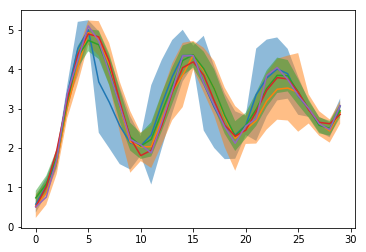

In [16]:
def plot_errorbar(x, y, error, linespec='-'):
    import matplotlib.pyplot as plt
    
    _l, = plt.plot(x, y, linespec)
    plt.fill_between(x, y-error, y+error, alpha=0.5, facecolor=_l.get_color())

plt.clf()
# plt.hold(1)
    
vis_i = 5

for m_c, sigma_c in zip(['mu_bw','mu_fw', 'mu_sm'], ['sigma_bw','sigma_fw', 'sigma_sm']):
    y = eval_data.loc[(vis_i, slice(None)), m_c].values
    error = eval_data.loc[(vis_i, slice(None)), sigma_c].values
    
    plot_errorbar(range(len(y)), y, 2*error)
    

th = eval_data.loc[(vis_i,slice(None)),['theta','thetaNoisy']].values
    
plt.plot(range(len(th)), th)

from matplotlib2tikz import save as tikz_save

tikz_save(
    'smooth_vs_filter_all_observed.tikz',
    figureheight = '\\figheight',
    figurewidth = '\\figwidth'
    )

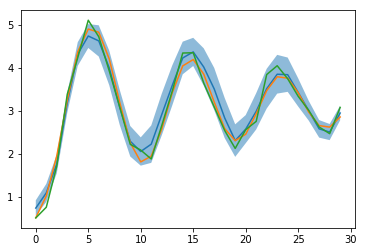

In [17]:
y = eval_data.loc[(vis_i, slice(None)), 'mu_sm'].values
error = eval_data.loc[(vis_i, slice(None)), 'sigma_sm'].values

plot_errorbar(range(len(y)), y, 2*error)

th = eval_data.loc[(vis_i,slice(None)),['theta', 'thetaNoisy']].values
    
plt.plot(range(len(th)), th)

In [20]:
eval_data.loc[(vis_i, slice(None)), 'sigma_bw'].values

array([ 0.10695006,  0.10733379,  0.10875337,  0.1158985 ,  0.34169158,
        0.12253044,  0.64422936,  0.58324398,  0.48696201,  0.33814441,
        0.12247744,  0.63041681,  0.56234135,  0.46611685,  0.32735343,
        0.12228633,  0.60092087,  0.51673551,  0.41814066,  0.30144334,
        0.12187236,  0.5854104 ,  0.48728252,  0.39964606,  0.3163204 ,
        0.24137126,  0.10077703,  0.0969981 ,  0.09564124,  0.09751211])